# Fetch Codebase and Models (git에서 higan프로젝트 파일 불러오기)
- 'Semantic Hierarchy Emerges in Deep Generative Representations for Scene Synthesis' 해당 논문에서 사용된 checkpoint 사용

In [ ]:
import os
os.chdir('/content')
CODE_DIR = 'higan'
!git clone https://github.com/genforce/higan.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')
!mkdir -p models/pretrain/pytorch
!wget https://www.dropbox.com/s/h1w7ld4hsvte5zf/stylegan_bedroom256_generator.pth?dl=1 -O models/pretrain/pytorch/stylegan_bedroom256_generator.pth --quiet
!wget https://www.dropbox.com/s/hwjyclj749qtp89/order_w.npy?dl=1 -O order_w_1k.npy --quiet


Cloning into 'higan'...
remote: Enumerating objects: 288, done.
remote: Counting objects: 100% (288/288), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 288 (delta 77), reused 263 (delta 58), pack-reused 0 (from 0)
Receiving objects: 100% (288/288), 16.22 MiB | 38.17 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [ ]:
!pip install ttach

# Define Utility Functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import io
import IPython.display
import cv2
import PIL.Image
import os
import numpy as np
from tqdm import tqdm
import torch

from models.helper import build_generator
from utils.logger import setup_logger
from utils.editor import get_layerwise_manipulation_strength
from utils.editor import manipulate


def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col

  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp

def build_model(model_name, logger=None):
  """Builds the generator by model name."""
  model = build_generator(model_name, logger=logger)
  return model

# latent_code를 반환해주는 함수
def sample_codes(model, num, seed=0, w1k_code=None):
  """Samples latent codes randomly."""
  np.random.seed(seed)
  if w1k_code is None:
    codes = generator.easy_sample(num)
    latent_codes = model.easy_sample(num=num, latent_space_type='w')
  else:
    latent_codes = w1k_code[np.random.randint(0, w1k_code.shape[0], num)]
  latent_codes = model.easy_synthesize(latent_codes=latent_codes,
                                       latent_space_type='w',
                                       generate_style=False,
                                       generate_image=False)['wp']
  return latent_codes

w1k_code = np.load('order_w_1k.npy')

# Build Generator

In [ ]:
indoor_model_name = "stylegan_bedroom"
indoor_model = build_model(indoor_model_name)

/content/higan/models/base_generator.py:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.weight_path)


# 이미지 저장 디렉토리 생성
- 다운로드한 테스트용 이미지를 넣어줄 폴더
- higan/test_image

In [ ]:
import os

# PNG 파일이 있는 디렉터리 경로 (코드와 동일한 경로라면 '.' 사용)
directory_path = './test_image'  # 여기서 'images'는 원하는 디렉터리 이름이야

# 디렉터리가 없는 경우 생성
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created.")

Directory './test_image' created.


# 예시 데이터(이미지) 읽어오기
 - (num sample, noise seed, image num)
 - num_sample : 생성 샘플 수
 - noise_seed : 노이즈 입력 파라미터 (고정값), 이후 동일한 이미지 생성 위해
 - image_num : 이미지 번호

In [ ]:
import os

# PNG 파일이 있는 디렉터리 경로 (코드와 동일한 경로라면 '.' 사용)
directory_path = './test_image'

# 결과를 저장할 리스트
num_sample_list = []
noise_seed_list = []
image_num_list = []

# 디렉터리 내 파일 순회
for file_name in os.listdir(directory_path):
    # PNG 파일만 처리
    if file_name.endswith('.png'):
        # 파일 이름에서 숫자 추출
        try:
            # 파일 이름에서 숫자 분리 (예: 100_234_6.png -> [100, 234, 6])
            num_sample, noise_seed, image_num = map(int, file_name.rstrip('.png').split('_'))

            # 각 숫자를 리스트에 저장
            num_sample_list.append(num_sample)
            noise_seed_list.append(noise_seed)
            image_num_list.append(image_num)
        except ValueError:
            print(f"Invalid file name format: {file_name}")


num_samples = num_sample_list[0]
noise_seed = noise_seed_list[0]
image_num = image_num_list[0]

print("Num Sample :", num_samples)
print("Noise Seed :", noise_seed)
print("Image Num :", image_num)

Num Sample : 10
Noise Seed : 156
Image Num : 0


# Sample Codes (Latent_code값 통해 이미지 생성)

In [ ]:
indoor_latent_codes = sample_codes(indoor_model, num_samples, noise_seed, w1k_code=w1k_code)
synthesis_kwargs = {'latent_space_type': 'wp'}
images = indoor_model.easy_synthesize(indoor_latent_codes, **synthesis_kwargs)['image']

# latent code 조정
 - 예시 이미지 distance(-3)으로 설정되어 있음
 - 조명 특징을 극대화하기 위해 예시데이터 조명 특징을 최대한 줄였음

In [ ]:
attribute_name = 'indoor_lighting'
path = f'boundaries/{indoor_model_name}/{attribute_name}_boundary.npy'
#print(f'Loading boundary from {path}')
try:
  boundary_file = np.load(path, allow_pickle=True).item()
  boundary = boundary_file['boundary']
  manipulate_layers = boundary_file['meta_data']['manipulate_layers']
except ValueError:
  boundary = np.load(path)
  if attribute_name == 'view':
    manipulate_layers = '0-4'
  else:
    manipulate_layers = '6-11'


if attribute_name == 'view':
  strength = [1.0 for _ in range(indoor_model.num_layers)]
else:
  strength = get_layerwise_manipulation_strength(
    indoor_model.num_layers, indoor_model.truncation_psi, indoor_model.truncation_layers)

distance = -3 # {min:-3.0, max:3.0, step:0.1}
indoor_codes = manipulate(latent_codes=indoor_latent_codes,
                     boundary=boundary,
                     start_distance=0,
                     end_distance=distance,
                     step=2,
                     layerwise_manipulation=True,
                     num_layers=indoor_model.num_layers,
                     manipulate_layers=manipulate_layers,
                     is_code_layerwise=True,
                     is_boundary_layerwise=False,
                     layerwise_manipulation_strength=strength)
images = indoor_model.easy_synthesize(indoor_codes[:, 1], latent_space_type='wp')['image']

In [ ]:
#np.save('generated_images.npy', images)  # 이미지 저장
np.save('latent_codes_1.npy', indoor_codes)  # latent space 저장

# 확인할 이미지

array([[[218, 212, 205],
        [214, 210, 206],
        [214, 210, 208],
        ...,
        [217, 213, 211],
        [219, 214, 209],
        [221, 214, 209]],

       [[212, 209, 208],
        [211, 207, 204],
        [211, 207, 205],
        ...,
        [215, 210, 207],
        [215, 211, 207],
        [215, 211, 208]],

       [[212, 208, 207],
        [211, 208, 205],
        [211, 207, 204],
        ...,
        [214, 210, 206],
        [216, 210, 206],
        [214, 210, 209]],

       ...,

       [[171, 166, 152],
        [167, 162, 147],
        [169, 162, 146],
        ...,
        [143, 137, 120],
        [145, 139, 123],
        [150, 145, 130]],

       [[170, 165, 154],
        [166, 161, 147],
        [170, 163, 148],
        ...,
        [142, 136, 119],
        [147, 141, 124],
        [150, 145, 132]],

       [[171, 167, 160],
        [165, 161, 151],
        [168, 163, 151],
        ...,
        [145, 139, 123],
        [147, 141, 125],
        [152, 145, 131]]], dtype=uint8)
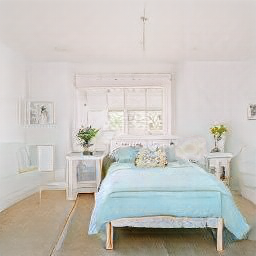

In [ ]:
save_image = images
save_image[image_num]

# latent code2 생성
 - 예시 이미지와 차이 극대화 위해 distance(3) 조명 attribute 크게 반영

In [ ]:
distance = 3 #{min:-3.0, max:3.0, step:0.1}
indoor_codes2 = manipulate(latent_codes=indoor_latent_codes,
                     boundary=boundary,
                     start_distance=0,
                     end_distance=distance,
                     step=2,
                     layerwise_manipulation=True,
                     num_layers=indoor_model.num_layers,
                     manipulate_layers=manipulate_layers,
                     is_code_layerwise=True,
                     is_boundary_layerwise=False,
                     layerwise_manipulation_strength=strength)

In [ ]:
# 생성된 이미지 저장
np.save('latent_codes_2.npy', indoor_codes2)  # latent space 저장

# 배치 추천 위치 생성
 - layer 6~11 (조명 attribute의 영향 최대)의 feature map 불러오기
 - latent 1, latent 2의 feature map에 대해서 Grad-CAM 추출
 - latent 1, latent 2 Grad_CAM의 가중치 맵 차이 계산
 - layer 별 차이값 누적
 - 차이값 기준으로 생성한 heatmap clustering
 - 가장 큰 차이값을 기준으로 최대 3가지 위치 추천

/content/higan/models/base_generator.py:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.weight_path)
/usr/local/lib/python3.10/dist-packages/

Cluster 1 Center Coordinates: (y: 139.68, x: 215.00)
Cluster 2 Center Coordinates: (y: 132.90, x: 86.51)
Cluster 3 Center Coordinates: (y: 150.75, x: 85.51)


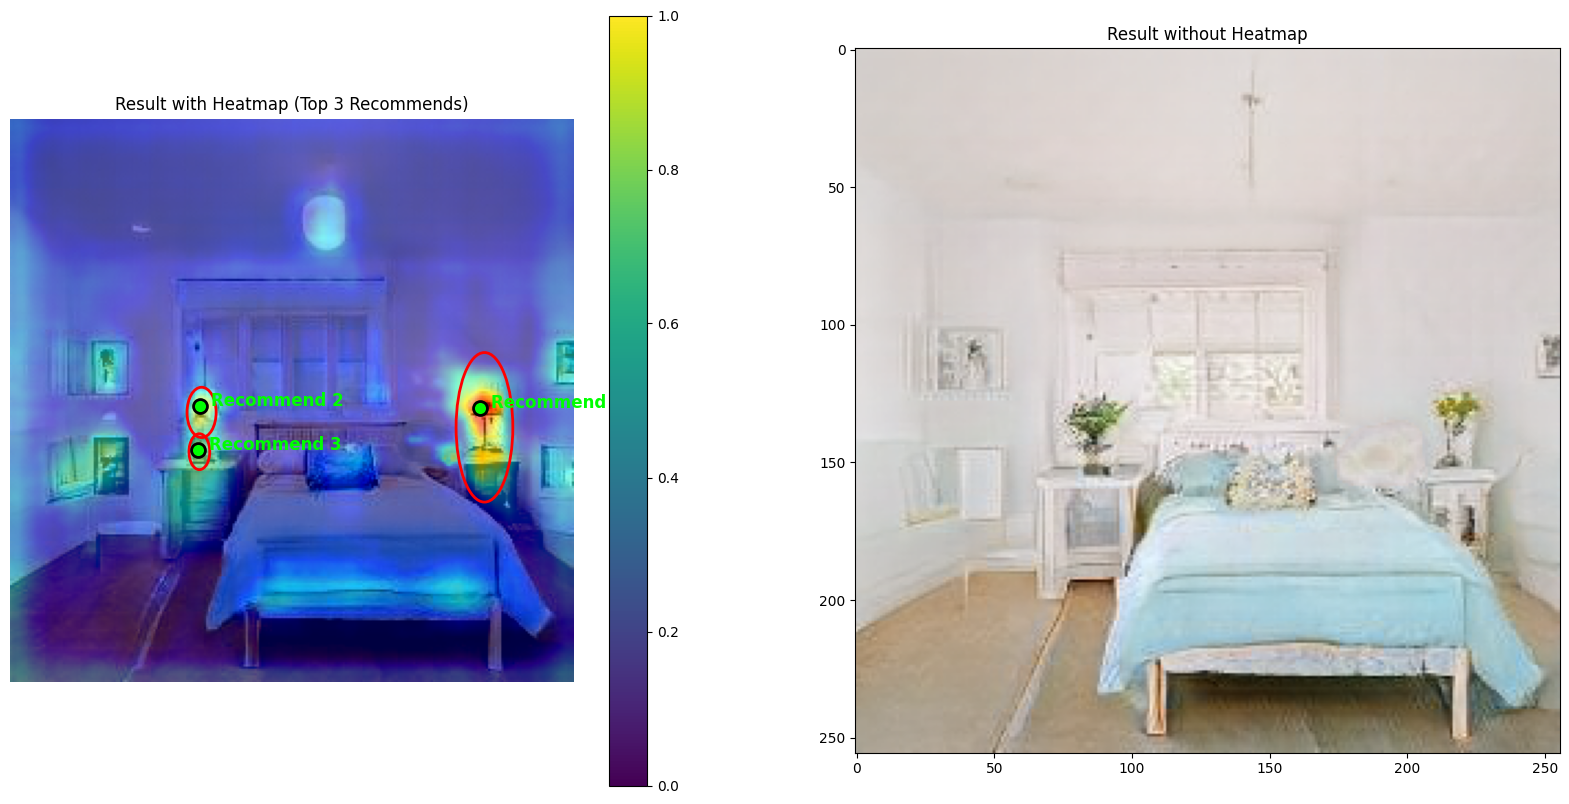

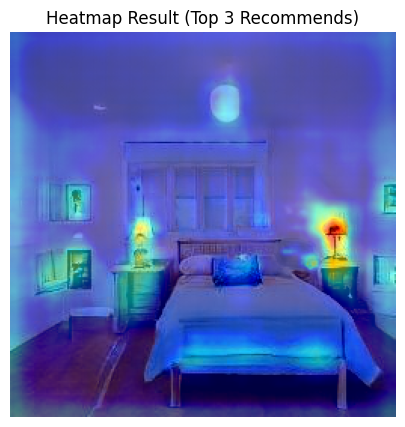

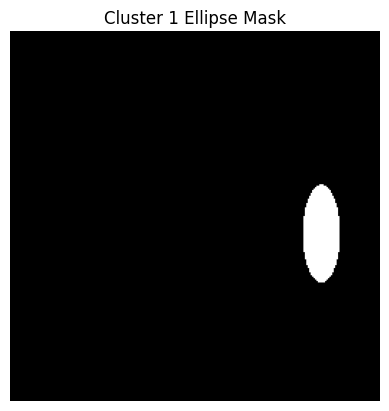

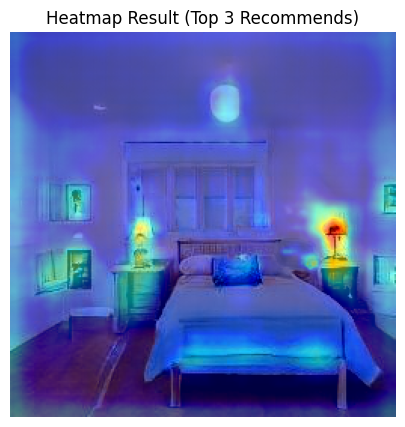

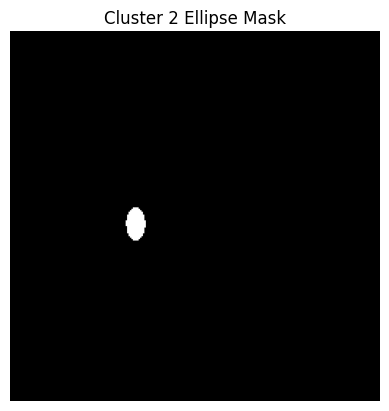

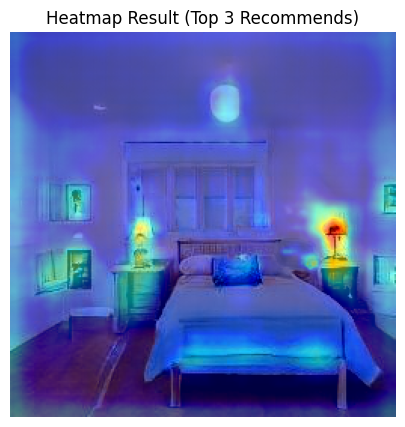

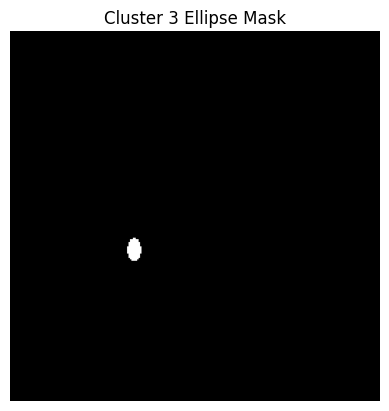

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.patches as patches
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import cv2
from sklearn.cluster import DBSCAN
from scipy.ndimage import maximum_position

# Boundary 파일 로드 함수 정의
def load_boundary(boundary_name, base_dir='boundaries/stylegan_bedroom'):
    path = os.path.join(base_dir, boundary_name)
    boundary_file = np.load(path, allow_pickle=True).item()
    boundary = boundary_file['boundary']
    manipulate_layers = boundary_file['meta_data']['manipulate_layers']
    return boundary, manipulate_layers

# Grad-CAM 계산 함수
def calculate_grad_cam(feature_map, gradients):
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])  # [C]
    grad_cam = torch.zeros_like(feature_map[0, 0])
    for i in range(feature_map.shape[1]):
        grad_cam += pooled_gradients[i] * feature_map[0, i]
    grad_cam = torch.relu(grad_cam)  # ReLU 적용
    grad_cam -= grad_cam.min()  # 정규화
    grad_cam /= grad_cam.max()
    return grad_cam.detach().cpu().numpy()

# Heatmap을 원본 이미지에 겹쳐서 시각화하는 함수
def overlay_heatmap_on_image(image, grad_cam, alpha=0.5, cmap='jet'):
    grad_cam_resized = cv2.resize(grad_cam, (image.shape[1], image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(grad_cam_resized * 255), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    if image.max() > 1:
        image = image / 255.0
    overlayed_image = alpha * heatmap / 255.0 + (1 - alpha) * image
    overlayed_image = np.clip(overlayed_image, 0, 1)
    return overlayed_image

# Heatmap 클러스터링 함수 (DBSCAN 활용)
def cluster_heatmap_with_dbscan(heatmap, eps=3, min_samples=5, prob_threshold=0.5):
    high_prob_indices = np.argwhere(heatmap >= prob_threshold)
    high_prob_values = heatmap[heatmap >= prob_threshold]

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(high_prob_indices)
    labels = db.labels_

    clusters = {}
    for cluster_id in set(labels):
        if cluster_id == -1:  # Noise 처리
            continue
        cluster_points = high_prob_indices[labels == cluster_id]
        cluster_values = high_prob_values[labels == cluster_id]
        clusters[cluster_id] = (cluster_points, cluster_values)

    return clusters

# Boundary 및 Latent Code 로드
boundary_name = 'indoor_lighting_boundary.npy'
boundary, manipulate_layers = load_boundary(boundary_name)
latent_codes1 = np.load('latent_codes_1.npy')
latent_codes2 = np.load('latent_codes_2.npy')

# Generator 모델 로드
from models.stylegan_generator import StyleGANGenerator
from models.model_settings import MODEL_POOL

model_name = 'stylegan_bedroom'
generator = StyleGANGenerator(model_name=model_name)
generator.weight_path = MODEL_POOL[model_name]['weight_path']
generator.load()
generator.net.eval()

# Gradients 저장 변수
gradients = {}

# 추천 위치 마스크 저장 디렉토리
output_dir = '.'

# Hook 설정 함수
def setup_hooks(generator, target_layers):
    hooks = []

    def forward_hook(module, input, output):
        module.feature_map = output

    def backward_hook(module, grad_in, grad_out):
        gradients[module.name] = grad_out[0]

    for layer_idx in target_layers:
        layer = getattr(generator.net.synthesis, f'layer{layer_idx}')
        layer.name = f'layer{layer_idx}'
        hooks.append(layer.register_forward_hook(forward_hook))
        hooks.append(layer.register_backward_hook(backward_hook))

    return hooks

# Hook 제거 함수
def remove_hooks(hooks):
    for hook in hooks:
        hook.remove()

# Grad-CAM 계산을 위한 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.net.to(device)

# ΔGrad-CAM 계산을 위한 준비
latent_codes = [latent_codes1, latent_codes2]
results = []
aggregate_grad_cam = None  # 초기화
target_resolution = (256, 256)  # 원하는 Heatmap 해상도 (e.g., 최종 이미지 해상도)

sample_index = image_num  # 사용할 샘플 인덱스
step_index = 1  # 0: 조작 전, 1: 조작 후 상태


# 레이어별 비율 설정
layer_percentages = {6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}

for layer_idx in range(6, 12):  # Layer 6~11
    grad_cams = []

    for latent_idx, latent_code in enumerate(latent_codes):
        if len(latent_code.shape) == 4:  # [N, Steps, L, D]
            latent_code = latent_code[sample_index, step_index, :, :]  # 샘플과 Step 선택
        elif len(latent_code.shape) == 3:  # [N, L, D]
            latent_code = latent_code[sample_index, :, :]
        latent_code = torch.from_numpy(latent_code).unsqueeze(0).float().to(device)
        latent_code.requires_grad = True

        # Hook 설정
        hooks = setup_hooks(generator, [layer_idx])

        # Latent Code 처리
        generated_output = generator.net.synthesis(latent_code)

        # Feature Map 및 Grad-CAM 계산
        layer = getattr(generator.net.synthesis, f'layer{layer_idx}')
        feature_map = layer.feature_map
        num_channels = feature_map.shape[1]

        boundary_layer = boundary[0, :num_channels]
        boundary_broadcasted = torch.tensor(boundary_layer[:, np.newaxis, np.newaxis]).to(device)

        influence_map = torch.sum(feature_map * boundary_broadcasted, dim=[2, 3])
        top_percentage = layer_percentages.get(layer_idx, 0.1)
        num_top_channels = max(1, int(num_channels * top_percentage))
        top_channels = torch.argsort(influence_map[0], descending=True)[:num_top_channels]

        score = torch.sum(feature_map[0, top_channels])
        generator.net.zero_grad()
        score.backward(retain_graph=True)

        grad_cam = calculate_grad_cam(feature_map, gradients[layer.name])
        grad_cams.append(grad_cam)

        # Hook 제거
        remove_hooks(hooks)

    # ΔGrad-CAM 계산
    if len(grad_cams) == 2:
        grad_cam_diff = grad_cams[1] - grad_cams[0]
        grad_cam_diff = np.clip(grad_cam_diff / (grad_cam_diff.max() - grad_cam_diff.min()), 0, 1)

        # Heatmap 크기 정규화
        grad_cam_diff_resized = cv2.resize(grad_cam_diff, target_resolution)

        # ΔGrad-CAM 누적
        if aggregate_grad_cam is None:
            aggregate_grad_cam = grad_cam_diff_resized
        else:
            aggregate_grad_cam += grad_cam_diff_resized

# 최대 표시할 recommend 개수 설정
max_recommend_to_display = 3  # 최대 표시할 recommend 개수

# Aggregate ΔGrad-CAM 계산 및 DBSCAN 클러스터링
if aggregate_grad_cam is not None:
    aggregate_grad_cam_normalized = aggregate_grad_cam / aggregate_grad_cam.max()

    clusters = cluster_heatmap_with_dbscan(aggregate_grad_cam_normalized, eps=5, min_samples=40, prob_threshold=0.5)

    # 클러스터를 높은 Heat 비중으로 정렬
    cluster_scores = {
        cluster_id: np.mean(cluster_values) for cluster_id, (_, cluster_values) in clusters.items()
    }
    sorted_clusters = sorted(cluster_scores.items(), key=lambda x: x[1], reverse=True)

    # 최대 표시할 recommend 개수 제한
    sorted_clusters = sorted_clusters[:max_recommend_to_display]

    latent_codes1 = latent_codes1[sample_index, : , :, :]
    latent_codes2 = torch.from_numpy(latent_codes2[sample_index, step_index , :, :]).unsqueeze(0).to(device).float()  # [1, 14, 512]

    generated_image_1 = indoor_model.easy_synthesize(latent_codes1, latent_space_type='wp')['image']
    generated_image_1 = generated_image_1[1]

    generated_image_2 = generator.net.synthesis(latent_codes2).detach().cpu().numpy()
    generated_image_2 = np.transpose(generated_image_2[0], (1, 2, 0))  # [1, 3, 256, 256] -> [256, 256, 3]
    generated_image_2 = np.clip(generated_image_2, 0, 1)

    # 최종 시각화
    result_image_2 = overlay_heatmap_on_image(generated_image_2, aggregate_grad_cam_normalized)

    # 결과 시각화: heatmap 포함 결과와 포함되지 않은 결과를 나란히 표시
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Heatmap이 포함된 결과
    mappable = axes[0].imshow(result_image_2)  # Heatmap 포함된 결과
    axes[0].set_title(f"Result with Heatmap (Top {max_recommend_to_display} Recommends)")
    plt.colorbar(mappable, ax=axes[0])  # Colorbar 추가

    scaling_factor = 3.0

    cluster_centers = []

    # 상위 recommend의 타원과 상위 포인트 표시 (Heatmap 포함된 결과)
    for i, (cluster_id, _) in enumerate(sorted_clusters):
        points, values = clusters[cluster_id]
        top_point = points[np.argmax(values)]
        y, x = top_point

       # 타원 중심과 범위 계산
        cluster_center = np.mean(points, axis=0)
        covariance_matrix = np.cov(points, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        major_axis = scaling_factor * 2 * np.sqrt(eigenvalues[1])  # 주축
        minor_axis = scaling_factor * 2 * np.sqrt(eigenvalues[0])  # 부축

        # 타원의 각도를 항상 수직으로 설정 (90도)
        angle = 90.0
        cluster_centers.append({
        "cluster_id": cluster_id,
        "center_y": cluster_center[0],
        "center_x": cluster_center[1]
        })
        print(f"Cluster {i + 1} Center Coordinates: (y: {cluster_center[0]:.2f}, x: {cluster_center[1]:.2f})")



    # 타원 추가
        ellipse = patches.Ellipse(
            cluster_center[::-1], width=major_axis, height=minor_axis, angle=angle,
            edgecolor='red', facecolor='none', linewidth=2
        )
        axes[0].add_patch(ellipse)

        # 상위 recommend 포인트 표시
        axes[0].scatter(x, y, color='lime', edgecolors='black', linewidth=2, s=100)
        axes[0].text(x + 5, y, f"Recommend {i+1}", color='lime', fontsize=12, weight='bold')

axes[0].axis('off')


# Heatmap이 없는 결과 (원본 이미지)
axes[1].imshow(generated_image_1)
axes[1].set_title("Result without Heatmap")

# 상위 recommend의 타원과 상위 포인트 표시 (원본 이미지)
for i, (cluster_id, _) in enumerate(sorted_clusters):
    points, values = clusters[cluster_id]
    top_point = points[np.argmax(values)]
    y, x = top_point

    # 타원 중심과 범위 계산
    cluster_center = np.mean(points, axis=0)
    covariance_matrix = np.cov(points, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    major_axis = scaling_factor * 2 * np.sqrt(eigenvalues[1])  # 주축
    minor_axis = scaling_factor * 2 * np.sqrt(eigenvalues[0])  # 부축
    # 타원의 각도를 항상 수직으로 설정 (90도)
    angle = 90.0

    #################

    # 마스크 생성
    mask = np.zeros_like(aggregate_grad_cam_normalized, dtype=np.uint8)
    y, x = np.meshgrid(range(mask.shape[0]), range(mask.shape[1]), indexing='ij')
    ellipse_mask = (
        ((x - cluster_center[1]) * np.cos(np.radians(angle)) +
         (y - cluster_center[0]) * np.sin(np.radians(angle)))**2 / (major_axis / 2)**2 +
        ((x - cluster_center[1]) * np.sin(np.radians(angle)) -
         (y - cluster_center[0]) * np.cos(np.radians(angle)))**2 / (minor_axis / 2)**2
    ) <= 1  # 타원 내부인지 확인

    mask[ellipse_mask] = 255  # 타원 내부를 흰색으로 설정

    # 마스크 저장
    mask_filename = os.path.join(output_dir, f"ellipse_mask_cluster_{i + 1}.png")
    cv2.imwrite(mask_filename, mask)

    # Heatmap 결과 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(result_image_2)
    plt.title(f"Heatmap Result (Top {max_recommend_to_display} Recommends)")
    plt.axis('off')
    plt.show()

    # 마스크 시각화
    plt.imshow(mask, cmap='gray')
    plt.title(f"Cluster {i + 1} Ellipse Mask")
    plt.axis('off')
    plt.show()


    #################

    # 타원 추가
    ellipse = patches.Ellipse(
        cluster_center[::-1], width=major_axis, height=minor_axis, angle=angle,
        edgecolor='blue', facecolor='none', linewidth=2
    )
    axes[1].add_patch(ellipse)

    # 상위 recommend 포인트 표시
    axes[1].scatter(x, y, color='orange', edgecolors='black', linewidth=2, s=100)
    axes[1].text(x + 5, y, f"Recommend {i+1}", color='orange', fontsize=12, weight='bold')

axes[1].axis('off')

plt.tight_layout()
plt.show()
